In [13]:
from sklearn.pipeline import Pipeline
import json
import matplotlib.pyplot as plt
import numpy
import math
import seaborn
%matplotlib inline

In [11]:
INSTANCES = "clickbait17-train-170331/instances.jsonl"
TRUTH     = "clickbait17-train-170331/truth.jsonl"

[    0.    10.    20.    30.    40.    50.    60.    70.    80.    90.
   100.   110.   120.   130.   140.   150.   160.   170.   180.   190.
   200.   210.   220.   230.   240.   250.   260.   270.   280.   290.
   300.   310.   320.   330.   340.   350.   360.   370.   380.   390.
   400.   410.   420.   430.   440.   450.   460.   470.   480.   490.
   500.   510.   520.   530.   540.   550.   560.   570.   580.   590.
   600.   610.   620.   630.   640.   650.   660.   670.   680.   690.
   700.   710.   720.   730.   740.   750.   760.   770.   780.   790.
   800.   810.   820.   830.   840.   850.   860.   870.   880.   890.
   900.   910.   920.   930.   940.   950.   960.   970.   980.   990.
  1000.]


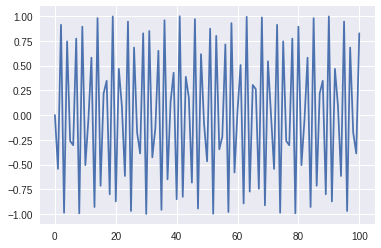

In [39]:
with open(INSTANCES, "r") as inf:
    test = inf.readlines()

# print(test[0])

vector = numpy.linspace(0,1000,101)
print(vector)
#plt.plot(vector)
plt.plot(numpy.sin(vector))

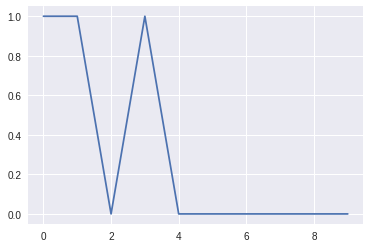